In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import glob
import numpy as np
import itertools

In [2]:
def bootstrap_gen(dataframe):
    return dataframe.sample(frac=1,replace=True)
def CVratio(experimentdata):
    return (experimentdata["<y>"].std(ddof=0)/experimentdata["<y>"].mean())/(experimentdata["<x>"].std(ddof=0)/experimentdata["<x>"].mean())
def xycorr(experimentdata):
    return experimentdata["<x>"].corr(experimentdata["<y>"])
def bootstrap_stderr_mean(experimentdata,f,n):
    bootstrap_fs = [f(bootstrap_gen(experimentdata)) for i in range(n)]
    return np.std(bootstrap_fs,ddof=0)/np.sqrt(len(experimentdata)),np.mean(bootstrap_fs)
def joinedbootstrap(experimentdata,n):
    rhos = []
    Cs = []
    for i in range(n):
        sample = bootstrap_gen(experimentdata)
        rhos.append(xycorr(sample))
        Cs.append(CVratio(sample))
    return np.std(Cs)/np.sqrt(len(experimentdata)),np.std(rhos)/np.sqrt(len(experimentdata))


files = glob.glob('no_fb_sims_largerange4_2023-02-02/*_simresults.tsv')
dfs = list()
for f in files:
    data = pd.read_csv(f,sep='\t')
    data['file'] = f
    dfs.append(data)

df = pd.concat(dfs, ignore_index=True)

In [5]:
folders = glob.glob('xfb_sims*')
df = pd.DataFrame()
for i,folder in enumerate(folders):
    files = glob.glob(folder+'/*_simresults.tsv')
    for f in files:
        data = pd.read_csv(f,sep='\t')
        simsettings = pd.read_csv(f[:-14]+'settings.tsv',sep='\t')
        simsettings = simsettings.drop(['cov thres','flux thres'],axis=1)
        data = pd.concat([data,simsettings.loc[simsettings.index.repeat(len(data))].reset_index(drop=True)],axis=1)
        data["file"] = f
        data['covcheck'] = data['cov thres'].apply(lambda x: all(float(i) <= 0.05 for i in x.strip('[]').split(',')))
        df = pd.concat([df,data],ignore_index=True)


In [10]:
cols = ["file","C","rho","std_rho","std_C","covcheck","numsims","F_x"]
pertdata = pd.DataFrame(columns=cols)
for f in df['file'].unique():
    #isolate data by parameter set
    experimentdata = df[df["file"] == f]
    #Total sims in the point
    nsims = len(experimentdata)
    #number of sims in data that didn't reach cov balance
    ncov = len(experimentdata[experimentdata["covcheck"]==False])
    #calculate quantity
    rho = xycorr(experimentdata)
    C_val = CVratio(experimentdata)
    #estimate standard error by bootstrapping
    std_Cval,std_rho = joinedbootstrap(experimentdata,1000)
    F_x = experimentdata["Fx"].mean()
    
    df2 = pd.DataFrame([[f,C_val,rho,std_rho,std_Cval,ncov,nsims,F_x]], columns= cols)
    pertdata = pd.concat([pertdata,df2])

All of the points, regardless if good or not

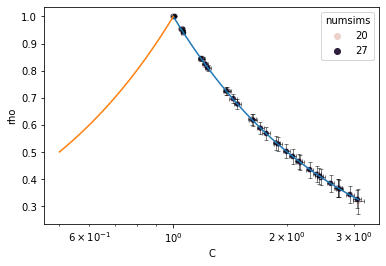

In [11]:
sns.scatterplot(data=pertdata,x="C",y="rho",hue='numsims')
plt.errorbar(y="rho", x="C", xerr="std_C", 
              yerr="std_rho", elinewidth=0.5,data=pertdata, label=None, capsize=2, capthick=0.5,color='k',fmt='none')
plt.plot(np.linspace(1,pertdata["C"].max()),1/np.linspace(1,pertdata["C"].max()))
plt.plot(np.linspace(0.5,1),np.linspace(0.5,1))
plt.xscale('log')

just points where all sims passed covcheck

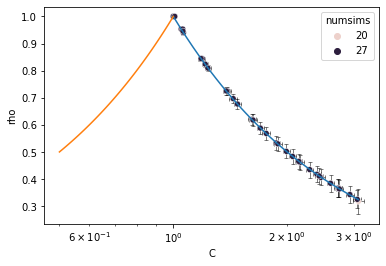

In [12]:
cleared = pertdata[pertdata["covcheck"]==0]
sns.scatterplot(data=cleared,x="C",y="rho",hue='numsims')
plt.errorbar(y="rho", x="C", xerr="std_C", 
              yerr="std_rho", elinewidth=0.5,data=cleared, label=None, capsize=2, capthick=0.5,color='k',fmt='none',zorder=-1)
plt.plot(np.linspace(1,cleared["C"].max()),1/np.linspace(1,cleared["C"].max()))
plt.plot(np.linspace(0.5,1),np.linspace(0.5,1))
plt.xscale('log')

Place to look at other slices

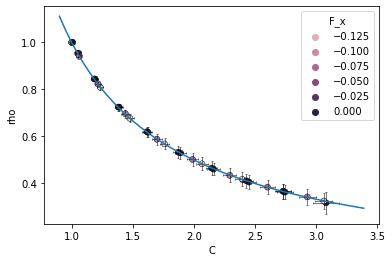

In [14]:
plotted = pertdata
sns.scatterplot(data=plotted,x="C",y="rho",hue='F_x',alpha=1,edgecolor='k')
plt.errorbar(y="rho", x="C", xerr="std_C", 
              yerr="std_rho", elinewidth=0.5,data=plotted, label=None, capsize=1, capthick=0.5,color='k',fmt='none')
plt.plot(np.linspace(0.9*plotted["C"].min(),(1.1)*plotted["C"].max()),1/np.linspace(0.9*plotted["C"].min(),(1.1)*plotted["C"].max()))

In [575]:
pertdata

,file,C,rho,std_rho,std_C,covcheck,numsims
0,constx_sims_perts_2023-Feb11_1243/pertset_10_p...,9.18587,0.076234,0.036956,0.316362,9,27
0,constx_sims_perts_2023-Feb11_1243/pertset_2_pa...,1.130519,0.894015,0.005187,0.017586,0,27
0,constx_sims_perts_2023-Feb11_1243/pertset_8_pa...,7.099337,0.137428,0.036296,0.212821,0,27
0,constx_sims_perts_2023-Feb11_1243/pertset_5_pa...,3.201931,0.307336,0.032498,0.078974,5,27
0,constx_sims_perts_2023-Feb11_1243/pertset_7_pa...,6.104364,0.162879,0.036687,0.166186,0,27
0,constx_sims_perts_2023-Feb11_1243/pertset_10_p...,9.102436,0.101437,0.038505,0.32092,0,27
0,constx_sims_perts_2023-Feb11_1243/pertset_8_pa...,7.172311,0.119412,0.037465,0.222415,9,27
0,constx_sims_perts_2023-Feb11_1243/pertset_2_pa...,1.119517,0.893652,0.005162,0.0175,0,27
0,constx_sims_perts_2023-Feb11_1243/pertset_7_pa...,6.160481,0.148055,0.036514,0.170934,9,27
0,constx_sims_perts_2023-Feb11_1243/pertset_5_pa...,3.17586,0.314974,0.034204,0.072505,0,27


In [562]:
df['rho_spont'] = df["cov(x,y)"]/np.sqrt(df["Var(x)"]*df["Var(y)"])
df['C_spont'] = (np.sqrt(df["Var(y)"])/df["<y>"])/(np.sqrt(df["Var(x)"])/df["<x>"])

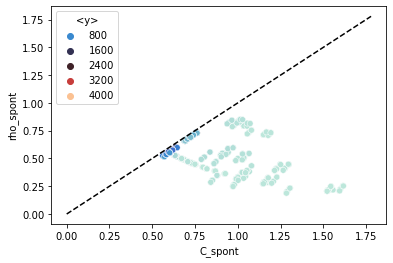

In [563]:
#bounds = 0.9*df['C_spont'].min(),1.1*df['C_spont'].max()
bounds=0,1.1*df['C_spont'].max()
t=np.linspace(bounds[0],bounds[1])
sns.scatterplot(data=df,x='C_spont',y='rho_spont',hue='<y>',palette='icefire')
plt.plot(t,t,'k--')

In [564]:
rs = df.groupby('file').apply(lambda x: x["Var(x)"].corr(x["Var(y)"]))

In [567]:
cs = df.groupby('file').apply(lambda x: (np.std(x["Var(y)"])/np.mean(x["Var(y)"]))/(np.std(x["Var(x)"])/np.mean(x["Var(x)"])) )

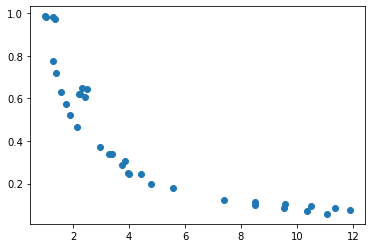

In [568]:
plt.scatter(cs,rs)